# COVID-19 Data Analysis and Forecasting

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Tweet_Analysis

## Introduction

### Problem and Purpose

#### This project will use forecasting to model Covid-19 deaths  based on current hospitalization, ventilator, and death data. I will be using API html links to bring in up to date data regularly. This project will use supervised learning in the form of ARIMA and SARIMAX in order to create time series death forecasts.

#### The purpose of this analysis is to provide an accurate forecast of Covid-19 related deaths as 2021 progresses.
#### Our challenges are -
#### * 1. Create multiple forecasts by creating forecasts for specific states
#### * 2. Build a forecast for the United States as a whole
#### * 3. Provide insights as to the urgency of making changes to how we are operating as a country

## Table of Contents

### Standard Libraries

In [1]:
from tensorflow.random import set_seed
import numpy as np

set_seed(42)
np.random.seed(42)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
import plotly.express as px
import plotly.io as pio
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
import pandas_datareader as pdr
import holidays
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output,State
# app = JupyterDash('our app')
# pio.templates

In [3]:
# import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, TensorBoard

In [4]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [5]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Custom Libraries

In [7]:
from Cust_Func import adf_test
from Cust_Func import sort_and_clean_df
from Cust_Func import return_arima_order
from Cust_Func import build_SARIMAX_forecast
from Cust_Func import create_NN_predict as create_nn
from Cust_Func import multivariate_nn_forecast as mv_forecast
from Cust_Func import make_model
from Cust_Func import state_dataframe
from Cust_Func import evaluate_predictions

## Explore Data

### Create New DataFrame

In [8]:
df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

### Plot of Ventilators and Deaths for Each State in One Graph

In [9]:
df_states['death'] = df_states['death'].fillna(0)
df_states['onVentilatorCurrently'] = df_states['onVentilatorCurrently'].fillna(0)

In [10]:
df_states = sort_and_clean_df(df_states,'onVentilatorCurrently',.05)

In [11]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [12]:
state_postal = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY']

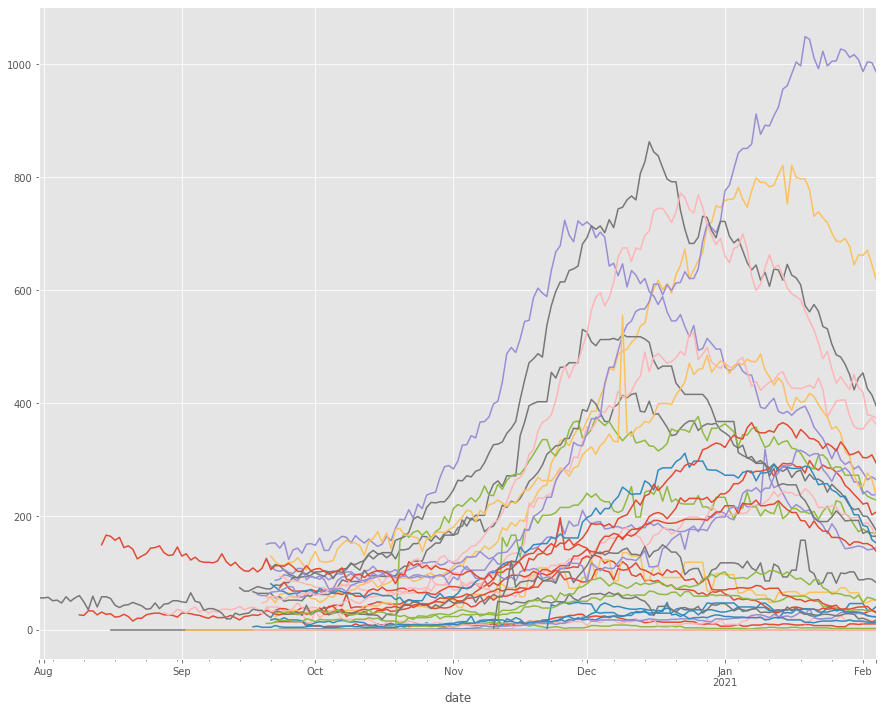

In [13]:
for state in state_postal:
    df_individual = df_states[df_states['state']==state].onVentilatorCurrently.sort_index()
    df_individual.index.freq = 'D'
    df_individual.iloc[200:].plot(figsize=(15,12));
    
# print(df_individual)

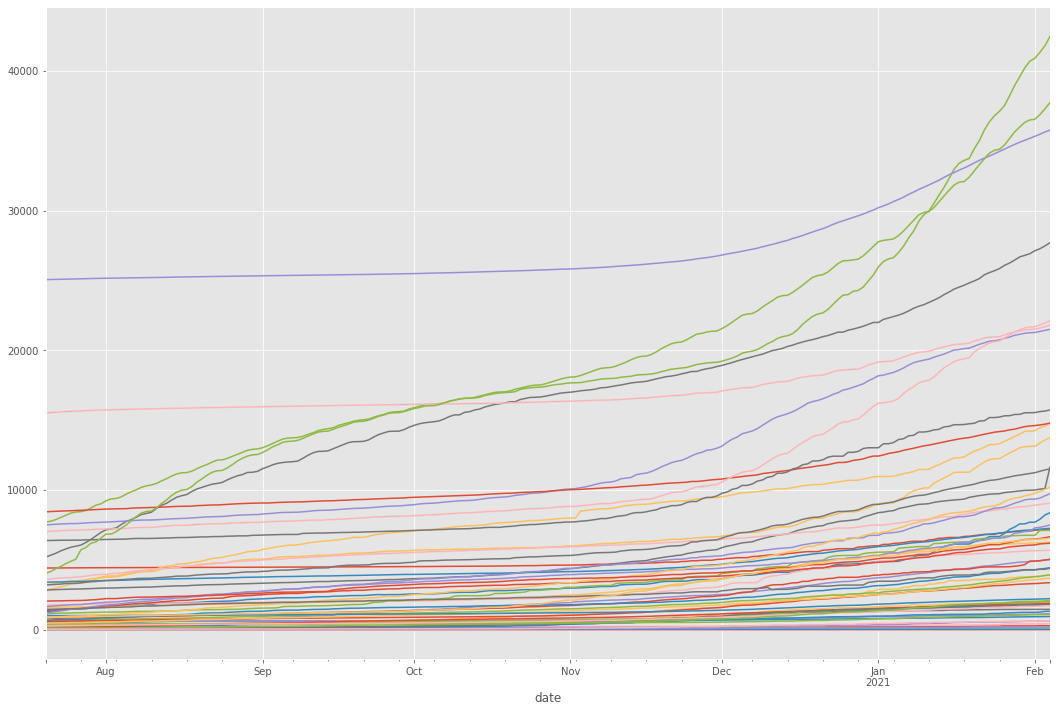

In [14]:
for state in state_postal:
    df_individual = df_states[df_states['state']==state].death
    df_individual.iloc[:200].plot(figsize=(18,12));
    
# print(df_individual)

### Plot Alaska Death Count

In [15]:
df_AK = df_states[df_states['state']=='AK'] # let's just use Alaska for now

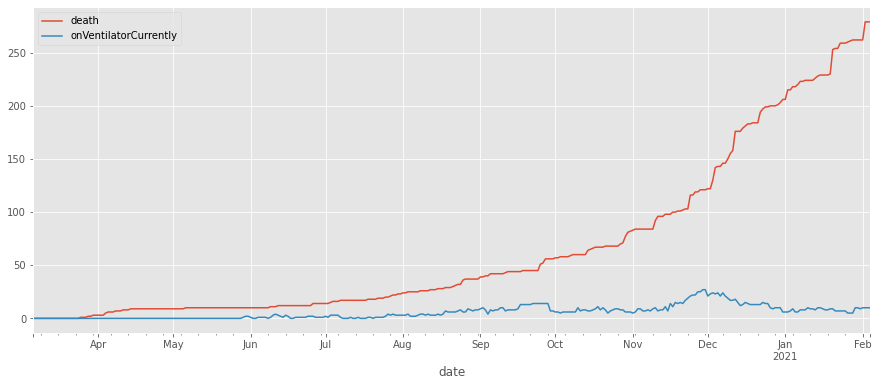

In [16]:
df_AK['death'].plot(figsize=(15,6),legend=True);
df_AK['onVentilatorCurrently'].plot(legend=True);

## Modeling and Forecasts

### Auto Regression Models

### Working Model with Exogenous Input (Ventilator forecast)

In [19]:
alaska_ref = state_dataframe(df_states, 'AK')

You now have a properly indexed dataframe that contains the state you are targeting.


In [20]:
alaska_df = state_dataframe(df_states, 'AK')

You now have a properly indexed dataframe that contains the state you are targeting.


In [21]:
stepwise_fit = return_arima_order(alaska_df, 'onVentilatorCurrently')

ARIMA order is:  (0, 1, 1)
Seasonal ARIMA order is:  (0, 0, 0, 52)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


In [22]:
# arima_order_AK = (1,2,1)
# seasonal_order_AK = (0,2,1,52)

arima_order_AK = stepwise_fit.order
seasonal_order_AK = stepwise_fit.seasonal_order

In [23]:
days=30

model = evaluate_predictions(alaska_df, 'onVentilatorCurrently',days=days,arima_order=arima_order_AK,seasonal_arima_order=seasonal_order_AK)

In [24]:
results = model.fit()

In [25]:
length = len(alaska_df)-days
train_data = alaska_df.iloc[:length]
test_data = alaska_df.iloc[length:]
start = length
end = len(alaska_df) - 1

predictions = results.predict(start,end,typ='endogenous').rename(f'SARIMAX{stepwise_fit.order} Predictions')

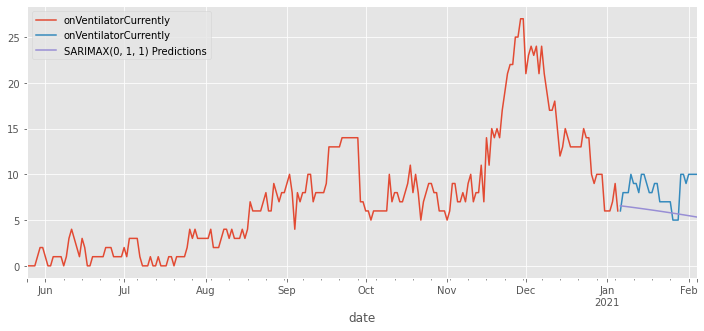

In [26]:
train_data.iloc[80:]['onVentilatorCurrently'].plot(figsize=(12,5),legend=True); 
test_data['onVentilatorCurrently'].plot(legend=True); 

predictions.plot(legend=True); 

In [27]:
# returns a results_forecast object
forecast_model = build_SARIMAX_forecast(alaska_df,'onVentilatorCurrently',days=days,arima_order=arima_order_AK,seasonal_arima_order=seasonal_order_AK)

In [28]:
forecast_results = forecast_model.fit()

In [29]:
start = len(alaska_df)
end = len(alaska_df) + days
forecast = forecast_results.predict(start,end,typ='endogenous').rename(f'SARIMAX{stepwise_fit.order} Predictions')

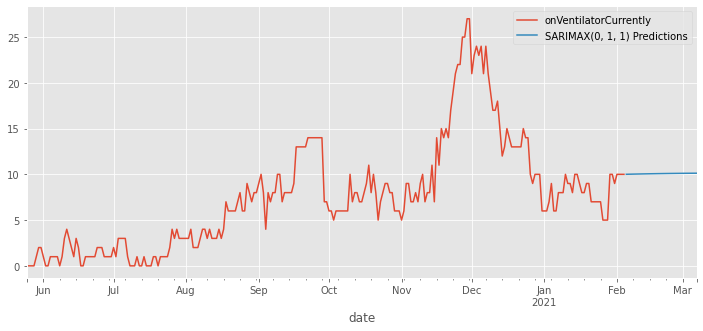

In [30]:
alaska_df['onVentilatorCurrently'].iloc[80:].plot(figsize=(12,5),legend=True); 
forecast.plot(legend=True); 

In [31]:
alaska_df.index.min()

Timestamp('2020-03-06 00:00:00', freq='D')

In [32]:
today = datetime.date(datetime.now())
td = timedelta(days=days)
future_date = today+td

rng = pd.date_range(alaska_df.index.min(),future_date,freq='D')
# new_df = pd.DataFrame(alaska_df)

In [33]:
alaska_df = alaska_df.reindex(rng)
alaska_df = alaska_df.set_index(rng)

In [45]:
alaska_df.tail()

,state,positive,negative,onVentilatorCurrently,death
2021-03-02,NaN,NaN,NaN,10.112937,NaN
2021-03-03,NaN,NaN,NaN,10.115181,NaN
2021-03-04,NaN,NaN,NaN,10.117268,NaN
2021-03-05,NaN,NaN,NaN,10.119197,NaN
2021-03-06,NaN,NaN,NaN,10.120969,NaN


In [35]:
# concatenate forecast data to the existing alaska dataframe
alaska_df['onVentilatorCurrently'] = alaska_df['onVentilatorCurrently'].fillna(forecast)

In [36]:
alaska_df

,state,positive,negative,onVentilatorCurrently,death
2020-03-06,AK,0.0,0.0,0.000000,0.0
2020-03-07,AK,0.0,0.0,0.000000,0.0
2020-03-08,AK,0.0,0.0,0.000000,0.0
2020-03-09,AK,0.0,0.0,0.000000,0.0
2020-03-10,AK,0.0,0.0,0.000000,0.0
...,...,...,...,...,...
2021-03-02,NaN,NaN,NaN,10.112937,NaN
2021-03-03,NaN,NaN,NaN,10.115181,NaN
2021-03-04,NaN,NaN,NaN,10.117268,NaN
2021-03-05,NaN,NaN,NaN,10.119197,NaN


In [37]:
stepwise_fit = return_arima_order(alaska_df.iloc[0:len(alaska_ref)], 'death')

arima_order_AK = stepwise_fit.order
seasonal_order_AK = stepwise_fit.seasonal_order

ARIMA order is:  (0, 2, 1)
Seasonal ARIMA order is:  (0, 0, 0, 52)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


In [38]:
# returns a results_forecast object
days = 30
x_forecast = build_SARIMAX_forecast(alaska_df,'death',exogenous_column='onVentilatorCurrently',days=days,arima_order=arima_order_AK,seasonal_arima_order=seasonal_order_AK)

In [39]:
model = x_forecast.fit()

In [46]:
start = len(alaska_df)
end = len(alaska_df) + days

forecast = model.get_forecast(steps=days)

In [82]:
forecast_interval = forecast.conf_int(alpha=.05) # 
predicted_mean = forecast.predicted_mean

In [83]:
length = -days
forecast_interval = forecast_interval[length:]
predicted_mean = predicted_mean[length:]

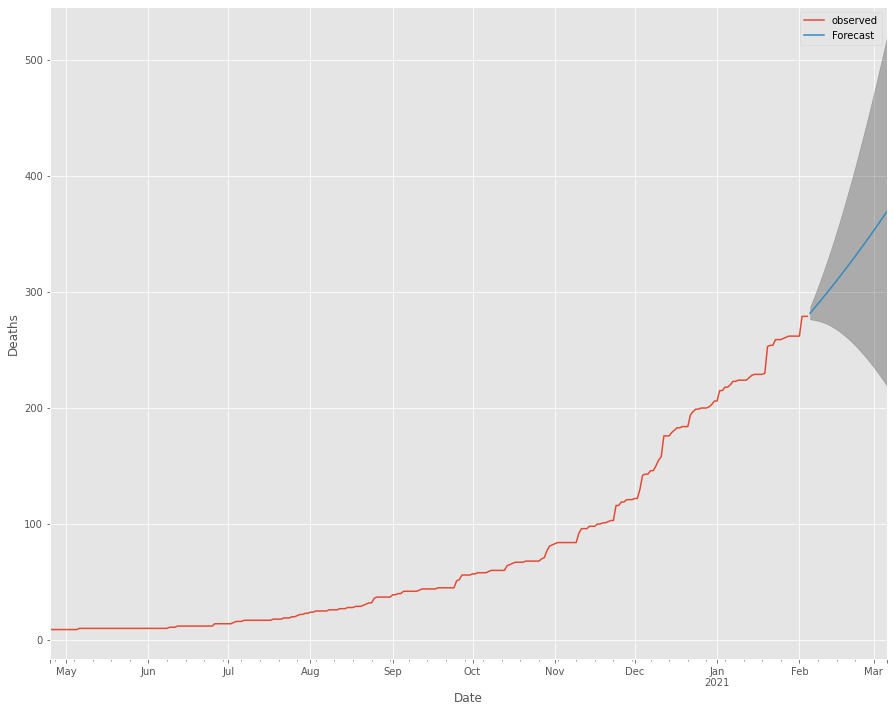

In [84]:
ax = alaska_df.iloc[50:]['death'].plot(label='observed', figsize=(15, 12))
predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_interval.index,
                forecast_interval.iloc[:, 0],
                forecast_interval.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

plt.legend()
plt.show()

### Alaska SARIMA Model

In [127]:
df_AK = df_AK.sort_index()

In [128]:
df_AK = df_AK.dropna(subset=['death'])
df_AK = df_AK.dropna(subset=['onVentilatorCurrently'])

In [38]:
df_alaska = pd.DataFrame(df_AK)

In [39]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-02-03 00:00:00
Length of dataframe:  335


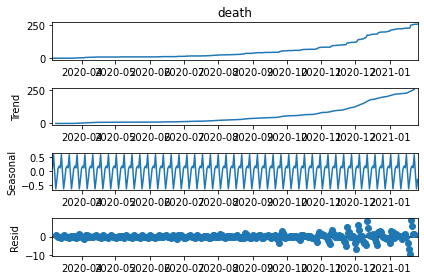

In [45]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [46]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [107]:
model = SARIMAX(df_alaska['death'], order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  death   No. Observations:                  327
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -713.899
Date:                Wed, 27 Jan 2021   AIC                           1431.798
Time:                        14:18:11   BIC                           1439.365
Sample:                    03-06-2020   HQIC                          1434.818
                         - 01-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9622      0.010    -97.310      0.000      -0.982      -0.943
sigma2         4.6990      0.080     58.831      0.000       4.542       4.856
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             24574.45
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             111.94   Skew:                             5.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# dont forget get_predict
predictions_AK = model.get_forecast(30)

In [110]:
predictions_AK.predicted_mean

2021-01-27    262.127515
2021-01-28    264.255031
2021-01-29    266.382546
2021-01-30    268.510062
2021-01-31    270.637577
2021-02-01    272.765093
2021-02-02    274.892608
2021-02-03    277.020124
2021-02-04    279.147639
2021-02-05    281.275155
2021-02-06    283.402670
2021-02-07    285.530186
2021-02-08    287.657701
2021-02-09    289.785217
2021-02-10    291.912732
2021-02-11    294.040248
2021-02-12    296.167763
2021-02-13    298.295279
2021-02-14    300.422794
2021-02-15    302.550310
2021-02-16    304.677825
2021-02-17    306.805341
2021-02-18    308.932856
2021-02-19    311.060372
2021-02-20    313.187887
2021-02-21    315.315403
2021-02-22    317.442918
2021-02-23    319.570434
2021-02-24    321.697949
2021-02-25    323.825465
Freq: D, Name: predicted_mean, dtype: float64

In [111]:
predictions_AK.predicted_mean
predictions_AK.conf_int(alpha=.05) # lower and upper confidence intervals, 
# phase4 appendix will tell you how to graph and shade in between these two plots

# # Get forecast 500 steps ahead in future
# prediction = output.get_forecast(steps=500)

# # Get confidence intervals of forecasts
# pred_conf = prediction.conf_int()

# ax = CO2.plot(label='observed', figsize=(20, 15))
# prediction.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='k', alpha=0.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('CO2 Levels')

# plt.legend()
# plt.show()

,lower death,upper death
2021-01-27,257.878874,266.376157
2021-01-28,258.131946,270.378116
2021-01-29,258.742179,274.022914
2021-01-30,259.523869,277.496255
2021-01-31,260.406590,280.868565
2021-02-01,261.354963,284.175223
2021-02-02,262.348400,287.436817
2021-02-03,263.373771,290.666476
2021-02-04,264.422152,293.873126
2021-02-05,265.487190,297.063120


In [47]:
stepwise_fit.order

(0, 2, 1)

In [48]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  327
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -712.275
Date:                Wed, 27 Jan 2021   AIC                           1430.549
Time:                        13:32:39   BIC                           1441.901
Sample:                             0   HQIC                          1435.080
                                - 327                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0075      0.005      1.434      0.151      -0.003       0.018
ma.L1         -0.9786      0.011    -90.282      0.000      -1.000      -0.957
sigma2         4.6441      0.153     30.365      0.000       4.344       4.944
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             25033.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              77.47   Skew:                             5.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
length = len(df_alaska)-45

In [50]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [51]:
train_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,AK,NaN,NaN,8.0,1.0,totalTestsViral,8.0,NaN,NaN,NaN,...,8,0,0,1cccb785fe70d960475d4b202a3d0fc678c81e41,0,0,0,0,0,NaN
2020-03-07,AK,NaN,NaN,12.0,2.0,totalTestsViral,12.0,NaN,NaN,NaN,...,12,0,0,a2776acac3d2b1dea060a3c20f4b508d5c00fd3d,0,0,0,0,0,NaN
2020-03-08,AK,NaN,NaN,14.0,6.0,totalTestsViral,14.0,NaN,NaN,NaN,...,14,0,0,ec0512b5cc8703196f5901589feb0640e43a851a,0,0,0,0,0,NaN
2020-03-09,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,1,d079fbd221af733f452c4c09a96059c1b7403d68,0,0,0,0,0,NaN
2020-03-10,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,0,3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-08,AK,36758.0,NaN,1052220.0,NaN,totalTestsViral,1088978.0,159.0,827.0,NaN,...,1088978,0,22,d1b8f602b924805487bf555f1724b7d951e7cc4e,0,0,0,0,0,NaN
2020-12-09,AK,37342.0,NaN,1062213.0,NaN,totalTestsViral,1099555.0,165.0,847.0,NaN,...,1099555,4,20,89f8425bebab112809cf24f94afbb0f6c8e68a3f,0,0,0,0,0,NaN
2020-12-10,AK,37962.0,NaN,1075398.0,NaN,totalTestsViral,1113360.0,164.0,860.0,NaN,...,1113360,5,13,e74e702804d6b430c17a184b4acbae511972b54c,0,0,0,0,0,NaN


In [52]:
test_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,AK,39738.0,NaN,1103360.0,NaN,totalTestsViral,1143098.0,139.0,886.0,NaN,...,1143098,0,3,5bb1f21bb99f720474d81fa05d9f04b51ecb4904,0,0,0,0,0,NaN
2020-12-14,AK,40160.0,NaN,1107400.0,NaN,totalTestsViral,1147560.0,140.0,889.0,NaN,...,1147560,0,3,e5a29d80105d770991491df6181016aba47409ad,0,0,0,0,0,NaN
2020-12-15,AK,40438.0,NaN,1117429.0,NaN,totalTestsViral,1157867.0,140.0,908.0,NaN,...,1157867,3,19,62c0dca8a4bef2c2565d6a16a5ad6d70a573a2c0,0,0,0,0,0,NaN
2020-12-16,AK,41041.0,NaN,1125104.0,NaN,totalTestsViral,1166145.0,146.0,921.0,NaN,...,1166145,2,13,5b761687026839854946df03828dae6122365638,0,0,0,0,0,NaN
2020-12-17,AK,41418.0,NaN,1134305.0,NaN,totalTestsViral,1175723.0,140.0,921.0,NaN,...,1175723,2,0,57da8abfc9d9087026c85e98491d26aa54906809,0,0,0,0,0,NaN
2020-12-18,AK,41905.0,NaN,1143017.0,NaN,totalTestsViral,1184922.0,142.0,928.0,NaN,...,1184922,0,7,50aa2030574b3546c4b6143421d3d5c399bb98dc,0,0,0,0,0,NaN
2020-12-19,AK,42235.0,NaN,1150883.0,NaN,totalTestsViral,1193118.0,146.0,935.0,NaN,...,1193118,1,7,2a8425eef0275e58bea9dc06ba2e331645ec88f8,0,0,0,0,0,NaN
2020-12-20,AK,42413.0,NaN,1154093.0,NaN,totalTestsViral,1196506.0,127.0,935.0,NaN,...,1196506,0,0,71eecf3c040776ea105c3616d3e155121564053f,0,0,0,0,0,NaN
2020-12-21,AK,42563.0,NaN,1158414.0,NaN,totalTestsViral,1200977.0,123.0,937.0,NaN,...,1200977,0,2,a77d2209ee0674792ffc3976e945ce90c5618488,0,0,0,0,0,NaN


In [53]:
model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  282
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -558.607
Date:                Wed, 27 Jan 2021   AIC                           1125.215
Time:                        13:32:40   BIC                           1139.754
Sample:                    03-06-2020   HQIC                          1131.046
                         - 12-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1355      0.250     -0.541      0.588      -0.626       0.355
drift          0.0010      0.001      0.960      0.337      -0.001       0.003
ma.L1         -0.6264      0.037    -17.021      0.0

In [54]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [55]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [56]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06',
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12'],
              dtype='datetime64[ns]', name='date', length=282, freq=None)

In [57]:
test_data.index

DatetimeIndex(['2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25',
               '2021-01-26'],
              dtype='datetime64[ns]', name='date', freq=None)

In [58]:
predictions_AK = pd.DataFrame(predictions_AK)

In [59]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [60]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [61]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-13 to 2021-01-26
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [62]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-13 to 2021-01-26
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


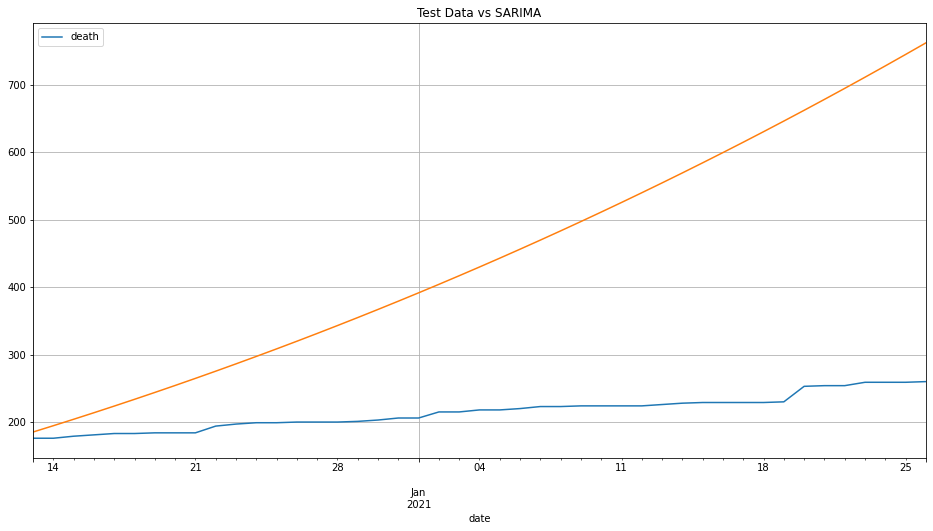

In [63]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [64]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  327
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -722.667
Date:                Wed, 27 Jan 2021   AIC                           1453.333
Time:                        13:32:40   BIC                           1468.469
Sample:                    03-06-2020   HQIC                          1459.374
                         - 01-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0390      0.101     -0.385      0.700      -0.237       0.159
drift          0.0002      0.000      0.556      0.578      -0.001       0.001
ma.L1         -0.8686      0.024    -36.348      0.0

In [65]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

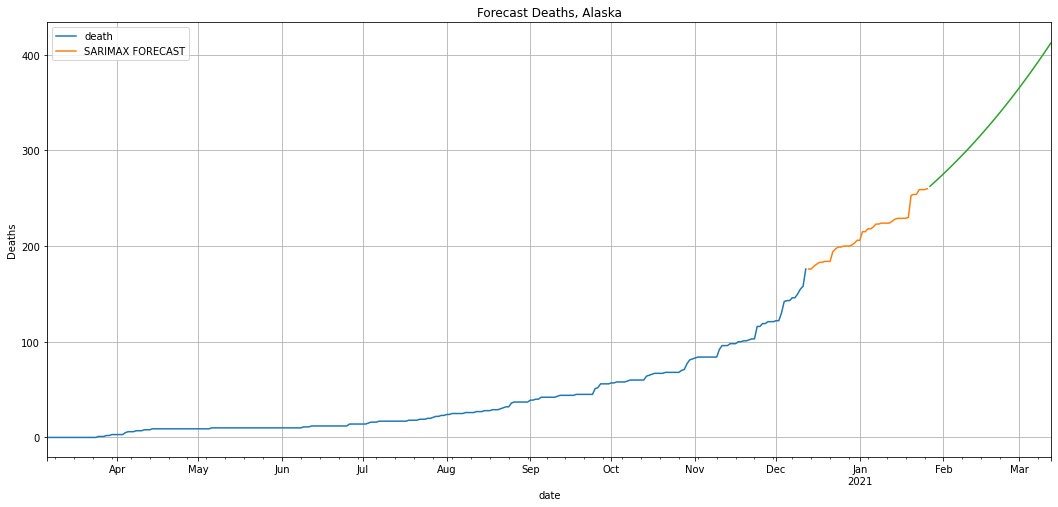

In [66]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

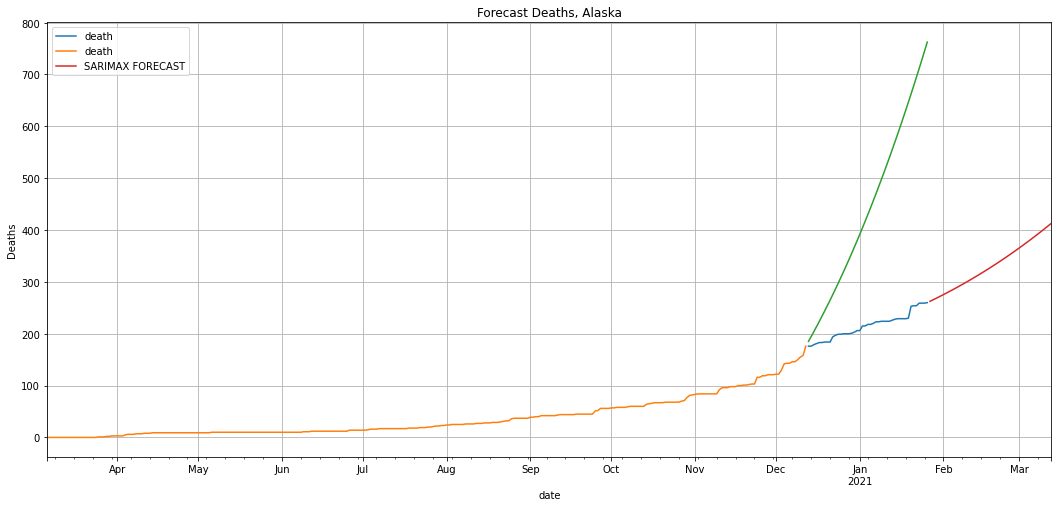

In [67]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

### Dashboard Dev, Work in Progress

In [68]:
# ## getting S&P500 symbols
# import requests
# url= 'https://api.covidtracking.com/v1/states/daily.csv'
# response = requests.get(url)
# response.status_code

In [69]:
# response.

In [70]:
# def summary_states(df_states,state_postal_code,days):
    
#     '''
#     *purpose: creates a SARIMA model based on datetime dataframe with column 'death'
#               and a state postal code under column 'state'
    
#     *inputs:
#     df_states: a dataframe of the state Covid data
#     state_postal_code: state postal code to get state related death data
#     days: number of days out you wish to forecast
#     '''
#     # create dataframe based on state_postal_code
#     df_state = df_states[df_states['state']==state_postal_code]    

#     # sort index, lowest index to oldest date, drop na's in death column
#     df_state = df_state.sort_index()
#     df_state = df_state.dropna(subset=['death'])
#     df_state_new = pd.DataFrame(df_state)

#     # create stepwise fit model, see summary
#     stepwise_fit = auto_arima(df_state_new['death'],start_p=0,start_q=0,max_p=10,
#                               max_q=10, seasonal=True, maxiter=1000, method='bfgs',
#                               n_jobs=-1,stepwise=True) 

#     # auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
#     ## find correct ARIMA order

#     arima_order = stepwise_fit.order

#     length = len(df_state_new)-days

#     df_actuals = df_state_new
#     train_data = df_state_new.iloc[:length]
#     test_data = df_state_new.iloc[length:]

#     model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     start = len(train_data)
#     end = len(train_data) + len(test_data) - 1

#     predictions_state = res.predict(start,end,typ='endogenous').rename(f'SARIMA{arima_order} Predictions')

#     # ensure predictions are in DataFrame format, label index as date to match df_alaska
#     # predictions_state = pd.DataFrame(predictions_state)
#     predictions_state.index.name = 'date'

#     train_data.index.freq = 'D'
#     test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
#     # perform sort_index on dataframe to correct. set frequencies to match for plotting
#     # on same visualization

#     # graph test vs. prediction data - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=4, label=f'SARIMA{arima_order} Predictions')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state);
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'Test Data vs SARIMA, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();

#     # train model for forecast
#     model = sm.tsa.statespace.SARIMAX(df_state['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     # create forecast
#     fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days, typ='endogenous').rename(f'SARIMA{arima_order} {days} Days Forecast')

#     # graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='y', lw=5, label=f'SARIMA{arima_order} Predictions'),
#                        Line2D([0], [0], color='g', lw=5, label=f'SARIMA{arima_order} {days} Day Forecast')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(train_data['death'])
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state)
#     ax.plot(fcast)
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'SARIMA {days} Day Forecast, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();
    
#     return df_actuals
#     return fcast # returning fcast to put into plot_forecast

In [71]:
# summary_states(df_states,'CA',30)

In [72]:
# def plot_forecast(df,states=[]):
#     if len(states)==0:
#         states=None
#     pfig = px.line(df)
#     return pfig

In [73]:
# def make_options(menu_choices,ignore_cols=['Date']):
#     """Returns list of dictionary with {'label':menu_choice,'value':menu_choice}"""
#     options = []
#     for choice in menu_choices:
#         if choice not in ignore_cols:
#             options.append({'State':choice,'Postal Code':choice})
#     return options

# state_options = make_options(state_postal)
# make_options(state_postal)

In [74]:
# pio.templates.default = "plotly_dark"

In [75]:
# df_state = df_states[df_states['state']=='CA']    

# # sort index, lowest index to oldest date, drop na's in death column
# df_state = df_state.sort_index()
# df_state = df_state.dropna(subset=['death'])
# df_actuals = pd.DataFrame(df_state)
    
# ## App here
# app = JupyterDash('App2')

# app.layout = html.Div(children=[
#     html.H1('Forecasting'),
#     html.H2('COVID-19 Deaths Forecast'),
#     dcc.Dropdown(id='states',options=state_options,multi=True),
#     dcc.Graph(id=f'{state}',figure=plot_forecast(df_actuals['death'],fcast))])
# app    

# @app.callback(Output('states','figure'),
#               [Input(f'{state}','value')])

# def update_forecast(states,state):
#     return plot_forecast(df_states[f'{state}'])
# app

In [76]:
# today = dt.date.today().strftime("%Y-%m-%d")

# def get_data(start_date=df_states,end_date=today,state_codes=state_postal_code):
    
#     data = {}
#     for state in state_codes:
#         try:
#             data[state] = pdr.DataReader(df_states,'yahoo',start_date,end_date)['death']
#         except:
#             print('Error with stock: '+stock)
#     df = pd.DataFrame(data).reset_index()
#     return df


# def plot_forecast_df(df=None,stocks=['FB','AAPL']):
#     if df is None:
#         df = get_data(stocks)#.reset_index()
#     stocks_exist = [s for s in stocks if s in df.columns]
#     pfig = px.scatter(df,x='Date',y=stocks_exist)
#     return pfig

# from jupyter_plotly_dash import JupyterDash
# app = JupyterDash('Example', 
#                   serve_locally=False)
# defaults = ['MSFT','AMZN']
# # df = get_data(date(2012, 1, 1))

# app.layout = html.Div(children = [
#     html.H1('Our AMAZING Dashboard'),
    
#     html.Div(children=[
#         html.Div(style={"border":'1px solid black','padding':'3px'},id='menu',children=[
#             html.H3('Enter state postal codes, separated by a comma.\nPress Enter to update.'),

#             dcc.Input(id='choose_stocks',value='MSFT,AMZN',
#                       placeholder='MSFT,AAPL',#,
#                          style={'width': '90%', 'height': 50}),           

#             dcc.DatePickerRange( id='my-date-picker-range',
#                                 start_date=date(2012,1,1),
#                                 min_date_allowed=date(2010, 1, 1),
#                                 max_date_allowed=today,#date.today(),#date(2021),
#                                 end_date=today,style={'width':'50%'}),#date.today()), #date(2017, 8, 25)),
#             html.Button('Submit',id='submit',style={'size':'40 px'})
    
#         ]),
        
#         dcc.Graph(id='line_plot')

#     ])
# ])

# @app.callback(Output('line_plot','figure'),
#               [Input('submit','n_clicks')],
#               [State('choose_stocks','value'),
#                State('my-date-picker-range', 'start_date'),
#                State('my-date-picker-range', 'end_date')])
# def update_stocks(n_clicks, stocks,start_date,end_date):
#     stocks = stocks.split(',')
#     plot_df = get_data(start_date,end_date,symbols=stocks)
#     return plot_stocks_df(df=plot_df,stocks=stocks)#,start_date,end_date)
    
# app

In [77]:
# data = {}
# days = 20

# for state in state_postal:
#     cas_state(df_states,state,days)

### Forecast by State, SARIMA

#### Here, provide DataFrame, postal code, and number of days in the future you wish to forecast. Code for this function is in Python file, Cust_Func.py

### Alaska

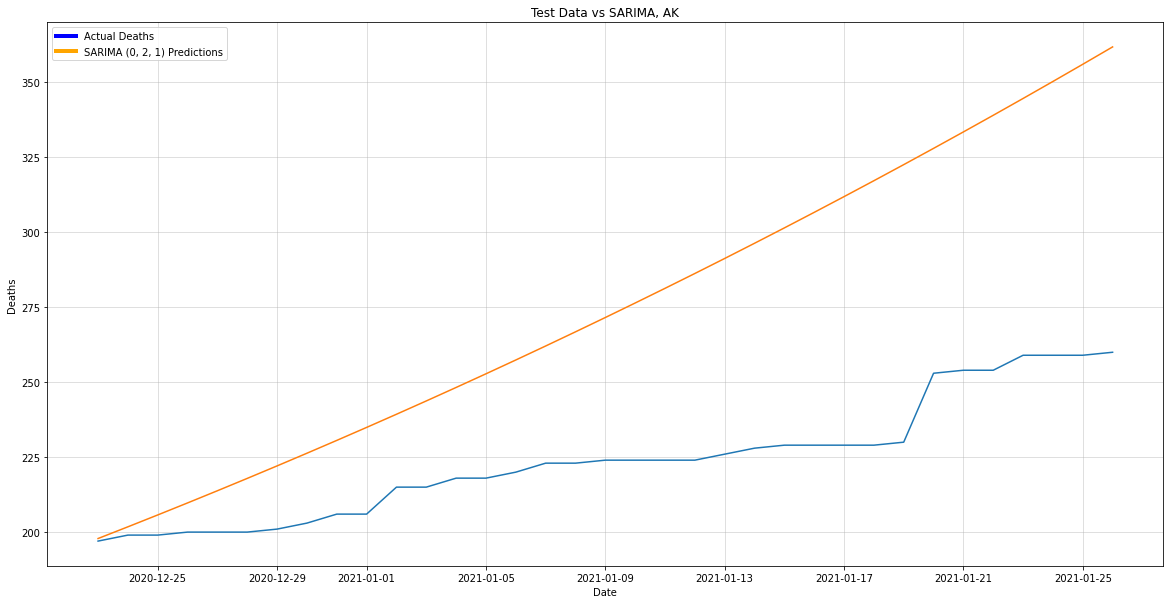

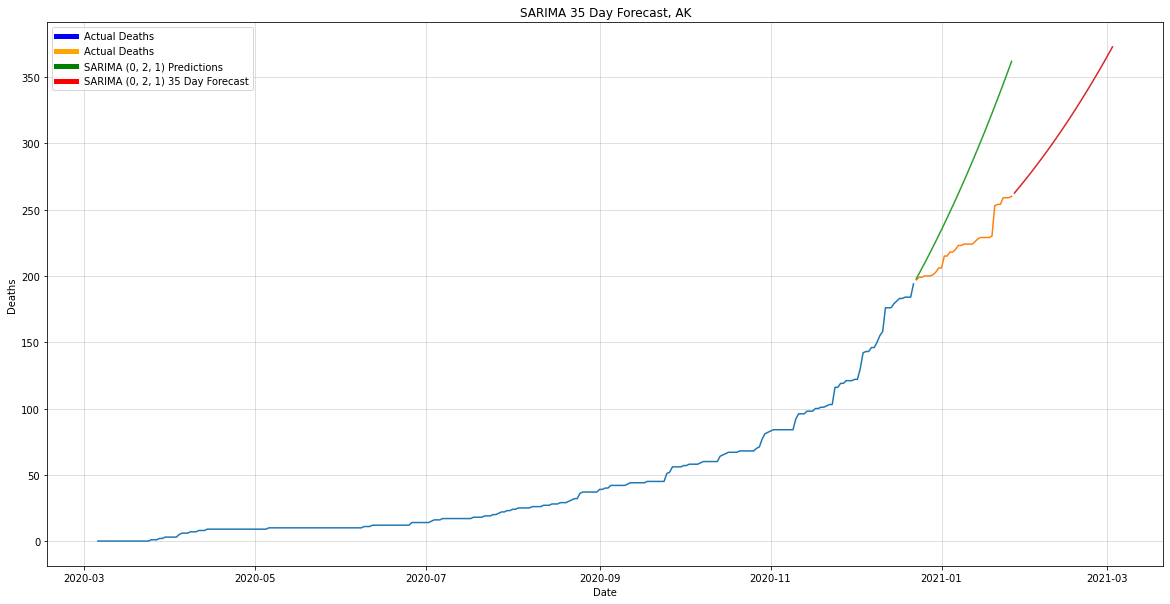

2021-02-27    357.765471
2021-02-28    361.453936
2021-03-01    365.183297
2021-03-02    368.953778
2021-03-03    372.765599
Freq: D, Name: SARIMA (0, 2, 1) 35 Days Forecast, dtype: float64

In [78]:
cas_state(df_states=df_states, state_postal_code='AK',days=35)

#### Based on a 35 day forecast as of data pulled on 01-24-2021 and good thru 01-23-2021, Alaska is seeing an increase in death rate. As of mid-December, the trend was flatter than the forecasted trend. Deaths currently sit at just over 250, but are projected to reach over 400 by the beginning of March. 

## Univariate Forecast with RNN

### Texas

Epoch 1/4
266/266 [==============================] - 8s 27ms/step - loss: 0.0363
Epoch 2/4
266/266 [==============================] - 7s 26ms/step - loss: 0.0017
Epoch 3/4
266/266 [==============================] - 7s 28ms/step - loss: 2.9707e-04
Epoch 4/4
266/266 [==============================] - 7s 26ms/step - loss: 4.4409e-04


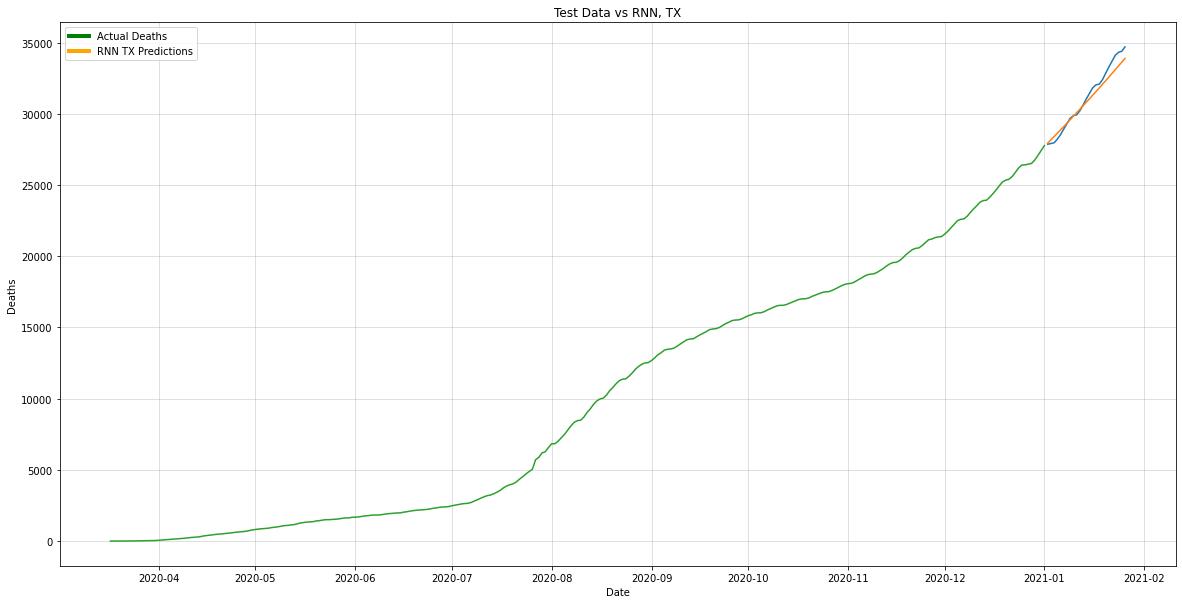

In [87]:
create_nn(df_states=df_states,state_postal_code='TX',days=25,epochs=4) # 

### Florida

Epoch 1/4
282/282 [==============================] - 8s 22ms/step - loss: 0.0268
Epoch 2/4
282/282 [==============================] - 6s 22ms/step - loss: 5.5386e-04
Epoch 3/4
282/282 [==============================] - 6s 21ms/step - loss: 2.9865e-04
Epoch 4/4
282/282 [==============================] - 6s 22ms/step - loss: 2.3872e-04


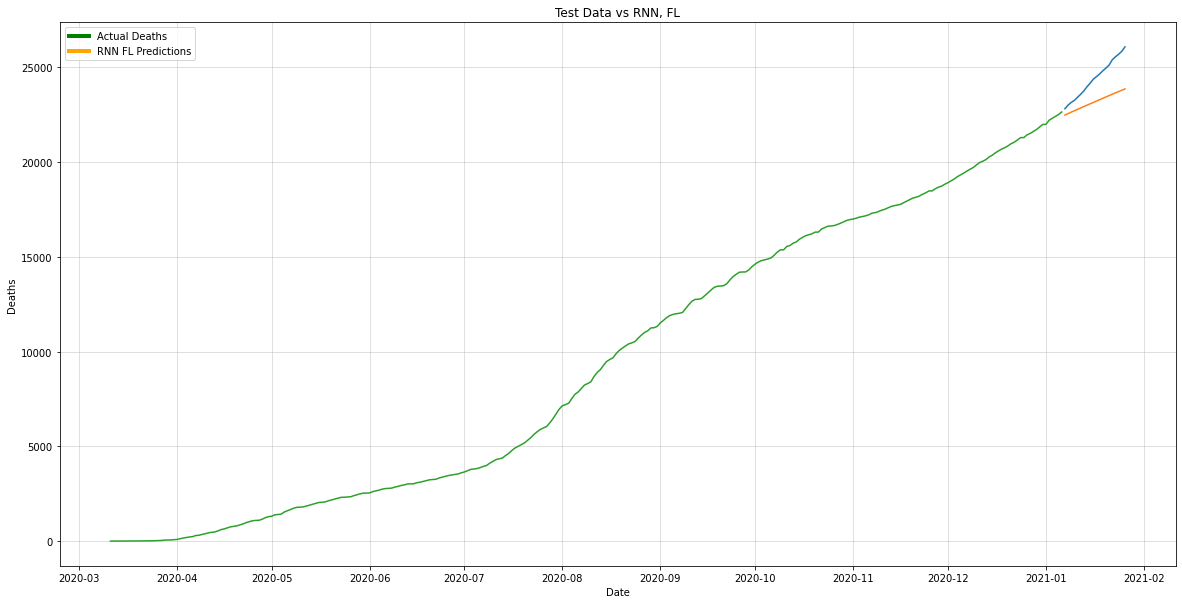

In [88]:
create_nn(df_states,'FL',20,epochs=4)

### California

Epoch 1/4
281/281 [==============================] - 7s 21ms/step - loss: 0.0226
Epoch 2/4
281/281 [==============================] - 7s 24ms/step - loss: 0.0016: 
Epoch 3/4
281/281 [==============================] - 6s 22ms/step - loss: 4.6964e-04
Epoch 4/4
281/281 [==============================] - 6s 22ms/step - loss: 7.7894e-04


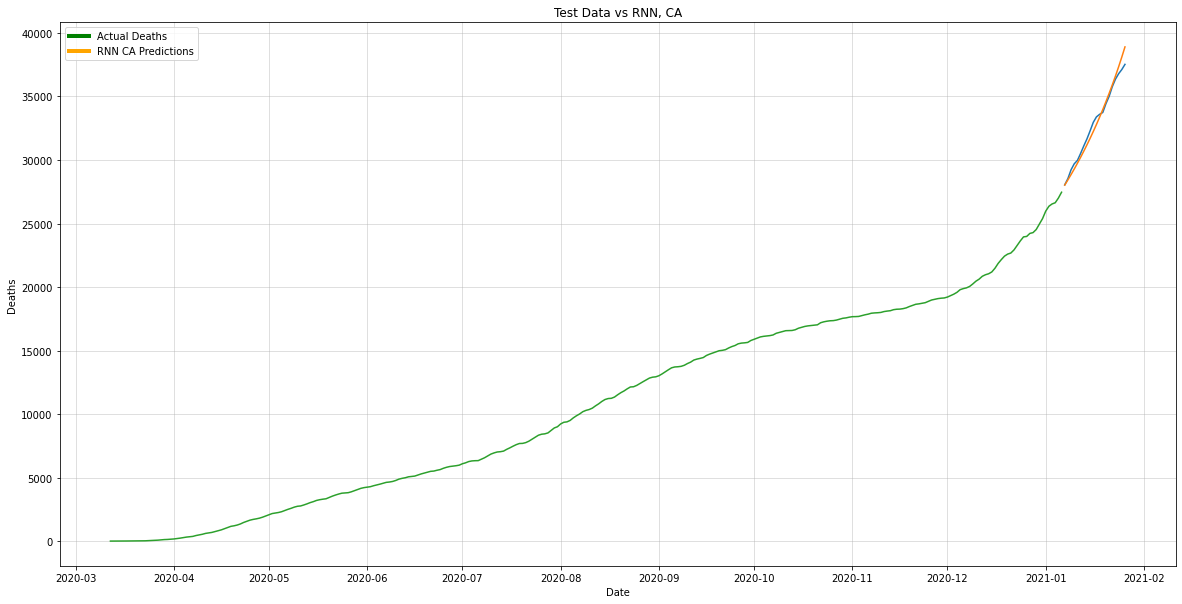

In [89]:
create_nn(df_states,'CA',20,epochs=4)

## Using an Exogenous Variable with SARIMAX

### pdq SARIMAX build

In [64]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = [0,1,2]

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [68]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(alaska_df['death'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
arima_order = ans_df['pdq'].loc[ans_df['aic'].idxmin()]
seasonal_arima = ans_df['pdqs'].loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_alaska['death'],
                                        exogenous=df_alaska['ventilator_forecast']
                                        order=arima_order, 
                                        seasonal_order=seasonal_arima, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [8]:
# adding holidays into dataframe below

In [95]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

calendar = calendar()
holidays = calendar.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)

df_whole_US['holiday'] = df_whole_US.index.isin(holidays)

In [96]:
df_states = clean_df(df_states,.05)

In [13]:
state_postal_code = 'TX'
days = 30

df_state = df_states[df_states['state']==state_postal_code]    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_state_new = pd.DataFrame(df_state)

#     ets_decomp = sd(df_state_new['death'])
#     ets_decomp.plot();

# create stepwise fit model, see summary
stepwise_fit = auto_arima(df_state_new['death'],seasonal=True,m=52,maxiter=2)

# auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
## find correct ARIMA order

arima_order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

length = len(df_state_new)-days

train_data = df_state_new.iloc[:length]
test_data = df_state_new.iloc[length:]

model = sm.tsa.statespace.SARIMAX(train_data['death'], trend='ct', seasonal_order=seasonal_order, 
                                  order=arima_order, enforce_invertibility=False)
res = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions_state = res.predict(start,end,dynamic=False).rename(f'SARIMAX {arima_order} Predictions')

# ensure predictions are in DataFrame format, label index as date to match df_alaska
predictions_state = pd.DataFrame(predictions_state)
predictions_state.index.name = 'date'

train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

# graph test vs. prediction data - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=4, label=f'SARIMAX {arima_order} Predictions')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(test_data['death'])
ax.plot(predictions_state);
ax.grid(b=True,alpha=.5)
plt.title(f'Test Data vs SARIMA, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in test_data.index:
    if test_data['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

error1 = mse(test_data['death'], predictions_state)
error2 = rmse(test_data['death'], predictions_state)

# print(f'SARIMAX{arima_order}{seasonal_order} MSE Error: {error1}')
# print(f'SARIMAX{arima_order}{seasonal_order} RMSE Error: {error2}')

# train model for forecast
model = sm.tsa.statespace.SARIMAX(df_state_new['death'],exog=df_state_new['holiday'],
                                  order=arima_order, seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
res = model.fit(disp=False)

# create forecast
exog_forecast = df_state_new[length:][['holiday']]
fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days-1,exog=exog_forecast).rename(f'SARIMAX{arima_order},{seasonal_order} {days} Days Forecast')

# graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='g', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} Predictions'),
                   Line2D([0], [0], color='r', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} {days} Day Forecast')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(train_data['death'])
ax.plot(test_data['death'])
ax.plot(predictions_state)
ax.plot(fcast)
ax.grid(b=True,alpha=.5)
plt.title(f'SARIMAX {days} Day Forecast, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in df_state_new.index:
    if df_state_new['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

last_predictions = len(fcast)-5
actual_numbers = fcast[last_predictions:]

return actual_numbers

MemoryError: Unable to allocate 28.1 MiB for an array with shape (108, 108, 316) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1004, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: Unable to allocate 28.1 MiB for an array with shape (108, 108, 316) and data type float64


AttributeError: Memoryview is not initialized

### Texas

In [97]:
create_SAX(df_states,'TX',30)

KeyboardInterrupt: 

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Texas deaths at 44,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### California

In [ ]:
create_SAX(df_states,'CA',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting California deaths at 51,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### Florida

In [ ]:
create_SAX(df_states,'FL',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Florida deaths at over 30,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### All States

In [ ]:
create_SAX_usa(df_whole_US,25)

## Multivariate Forecast with RNN

### Data Import and Ventilator/Death Plot

In [97]:
# initialize Df
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

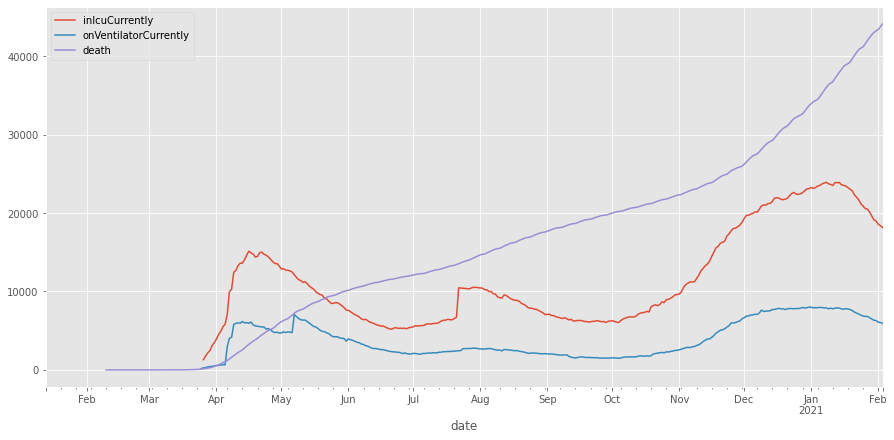

In [98]:
# we can see some lag here, common sense tells us we will probably see a 
#decrease in death rate after ICU and Ventilator populations fall. 
df_whole_US['inIcuCurrently'].plot(legend=True, figsize=(15,7))
df_whole_US['onVentilatorCurrently'].plot(legend=True, figsize=(15,7))
(df_whole_US['death']/10).plot(legend=True);  # to scale to other graphs

['death', 'onVentilatorCurrently']


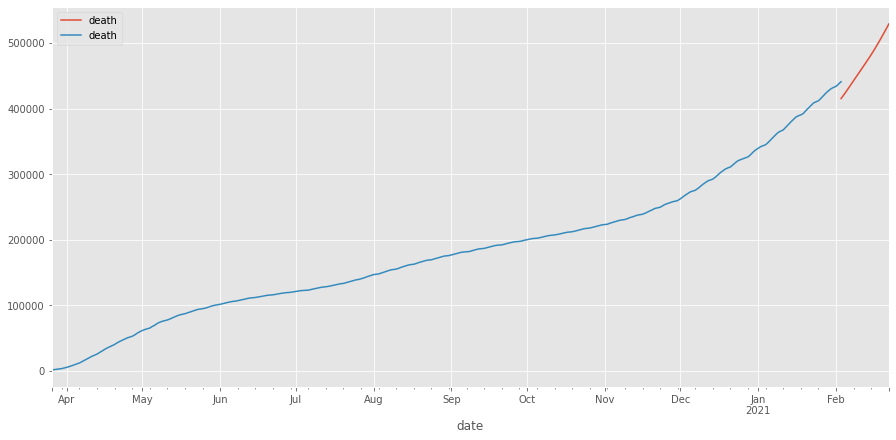

In [99]:
mv_forecast(df_whole_US,days_to_train=50,days_to_forecast=20,epochs=100) 
#hyperparameters to optimize days to train?

In [ ]:
# right now deaths is running total, in icu currently is the current value. utility
# slash usefulness are slightly different.
# currently indicates pressure on the healthcare system

# Feed in a ventilator forecast into the exogenous SARIMAX functions to
# improve the modeling while adding sophistication. make this and return this
# in a separate function. 

## Questions

### Question 1

### Question 2

### Question 3

## Conclusions

## Future Work